In [1]:

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import random
from sklearn.metrics import mean_squared_error

In [2]:
# Loading data into numpy arrays
inp_paras = np.load('data/inp_paras_995.npy')
aoas_opt = np.load('data/aoas_opt_995.npy')
airfoils_opt = np.load('data/airfoils_opt_995.npy')

airfoils_opt_new = airfoils_opt.reshape(airfoils_opt.shape[0], -1)
aoas_opt=aoas_opt.reshape(995,-1)
new_paras = np.concatenate((inp_paras,aoas_opt),axis=1)
print(new_paras.shape)
print(aoas_opt.shape)
print(airfoils_opt_new.shape)

(995, 4)
(995, 1)
(995, 384)


In [3]:
indices = np.arange(len(new_paras))
X_trainval, X_test, y_trainval, y_test, trainval_idx, test_set_idx = train_test_split(new_paras, airfoils_opt_new,indices, test_size=0.10, random_state=42)

# Standardize using training data only
scaler = StandardScaler()
X_trainval_std = scaler.fit_transform(X_trainval)
X_test_std = scaler.transform(X_test)

k = 6
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
# DNN Building
# Tanh(Linear) --> ReLU(Linear) --> Linear --> Ouput
# 2 Hidden Layers with ReLU activations

class Airfoil_NN(nn.Module):
    def __init__(self, output_param, input_param=4, neurons_per_layer=[3, 3]):
        super().__init__()
        self.hidden1 = nn.Linear(input_param, neurons_per_layer[0])
        self.act1 = nn.Tanh()
        self.hidden2 = nn.Linear(neurons_per_layer[0], neurons_per_layer[1])
        self.act2 = nn.ReLU()
        self.output = nn.Linear(neurons_per_layer[1], output_param)

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        
        x = self.output(x)
        return x

fold_train_loss = []
fold_val_loss = []

# k-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X_trainval_std)):

    fold_train = []
    fold_test = []

    print(f"Fold {fold + 1}/{k}")

    # Split data
    x_train, x_val = X_trainval_std[train_idx], X_trainval_std[test_idx]
    y_train, y_val = y_trainval[train_idx],y_trainval[test_idx]

    # Apply PCA
    pca = PCA(n_components=10)
    y_train_pca = pca.fit_transform(y_train)
    y_val_pca = pca.transform(y_val)

    # Convert to tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_pca, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_pca, dtype=torch.float32)

    # Model
    model = Airfoil_NN(output_param=10, input_param=4,
                       neurons_per_layer=[32, 64])

    # Loss & Optimizer
    loss_fn = nn.HuberLoss(reduction='mean', delta=0.001) # Less senstive to outlier than MSE
    optimizer = optim.Adam(model.parameters(), lr=0.01,eps=1e-6,weight_decay=1e-6)

    n_epochs = 120
    batch_size = 72

    # Training Loop
    for epoch in range(n_epochs+1):
        model.train()
        for i in range(0, len(x_train_tensor), batch_size):
            Xbatch = x_train_tensor[i:i+batch_size]
            ybatch = y_train_tensor[i:i+batch_size]

            #print(Xbatch.shape)
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Performance Monitoring
        if (epoch % 20 == 0):
            model.eval()
            with torch.no_grad():
                val_pred = model(x_val_tensor)
                val_loss = loss_fn(val_pred, y_val_tensor).item()
                print(
                    f"Epoch {epoch}: Train Loss = {loss.item():.10f}, Validation Loss = {val_loss:.10f}")
                fold_train.append(loss.item())
                fold_test.append(val_loss)

    fold_train_loss.append(fold_train)
    fold_val_loss.append(fold_test)

Fold 1/6
Epoch 0: Train Loss = 0.0000420185, Validation Loss = 0.0000419506
Epoch 20: Train Loss = 0.0000135390, Validation Loss = 0.0000177088
Epoch 40: Train Loss = 0.0000128502, Validation Loss = 0.0000163318
Epoch 60: Train Loss = 0.0000123288, Validation Loss = 0.0000157138
Epoch 80: Train Loss = 0.0000119110, Validation Loss = 0.0000158297
Epoch 100: Train Loss = 0.0000118111, Validation Loss = 0.0000157388
Epoch 120: Train Loss = 0.0000115192, Validation Loss = 0.0000155919
Fold 2/6
Epoch 0: Train Loss = 0.0000493007, Validation Loss = 0.0000411208
Epoch 20: Train Loss = 0.0000191225, Validation Loss = 0.0000135018
Epoch 40: Train Loss = 0.0000182688, Validation Loss = 0.0000125261
Epoch 60: Train Loss = 0.0000171496, Validation Loss = 0.0000119332
Epoch 80: Train Loss = 0.0000166427, Validation Loss = 0.0000112438
Epoch 100: Train Loss = 0.0000154284, Validation Loss = 0.0000111083
Epoch 120: Train Loss = 0.0000156076, Validation Loss = 0.0000116593
Fold 3/6
Epoch 0: Train Loss

In [ ]:
# Train final model 
test_data_loss = []
latent_dim = 10
final_model = Airfoil_NN(output_param=latent_dim,
                         input_param=4, neurons_per_layer=[32, 64])
criterion = nn.HuberLoss(reduction='mean', delta=0.001)
optimizer = optim.Adam(final_model.parameters(), lr=0.01,
                       eps=1e-6, weight_decay=1e-6)

# Apply PCA to training-validation data
pca = PCA(n_components=latent_dim)
y_trainval_pca = pca.fit_transform(y_trainval)

X_tensor = torch.FloatTensor(X_trainval_std)
y_tensor = torch.FloatTensor(y_trainval_pca)

n_epochs = 120
for epoch in range(n_epochs+1):
    final_model.train()
    optimizer.zero_grad()
    output = final_model(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
        test_data_loss.append(loss.item())

# Final evaluation on test set
final_model.eval()
with torch.no_grad():
    y_test_pca = pca.transform(y_test)
    test_preds = final_model(torch.FloatTensor(X_test_std))
    test_loss = criterion(test_preds, torch.FloatTensor(y_test_pca))

    # Inverse transform predictions back to original space
    reconstructed_airfoils = pca.inverse_transform(test_preds.numpy())
    reconstructed_airfoils = reconstructed_airfoils.reshape(-1, 192, 2)

    original_airfoils = airfoils_opt[test_set_idx]  # Select only test set indices
    original_airfoils = original_airfoils.reshape(-1, 192, 2)

    print(f"Final Test Loss: {test_loss.item():.6f}")
    mse_reconstruction = mean_squared_error(
        original_airfoils.reshape(original_airfoils.shape[0], -1),
        reconstructed_airfoils.reshape(reconstructed_airfoils.shape[0], -1)
    )
    print(f"Reconstruction MSE (Original Space): {mse_reconstruction:.6f}")

Epoch 0: Loss = 0.000142
Epoch 20: Loss = 0.000030
Epoch 40: Loss = 0.000023
Epoch 60: Loss = 0.000021
Epoch 80: Loss = 0.000020
Epoch 100: Loss = 0.000018
Epoch 120: Loss = 0.000015
Final Test Loss: 0.000018
Reconstruction MSE (Original Space): 0.000073


In [9]:
print(f"Validation Set Airfoil IDs in last fold: {test_set_idx.tolist()}")

Validation Set Airfoil IDs in last fold: [920, 525, 567, 657, 633, 429, 857, 712, 174, 604, 867, 449, 846, 580, 76, 371, 720, 136, 158, 290, 858, 321, 759, 70, 355, 359, 107, 265, 827, 139, 184, 728, 688, 943, 305, 811, 306, 649, 972, 323, 59, 298, 628, 618, 370, 23, 30, 757, 10, 514, 737, 598, 810, 551, 620, 334, 237, 591, 198, 430, 363, 532, 404, 96, 583, 723, 832, 235, 312, 673, 937, 39, 213, 482, 933, 66, 924, 67, 883, 485, 168, 318, 687, 362, 581, 215, 806, 294, 88, 63, 905, 710, 597, 895, 210, 652, 817, 954, 209, 874]


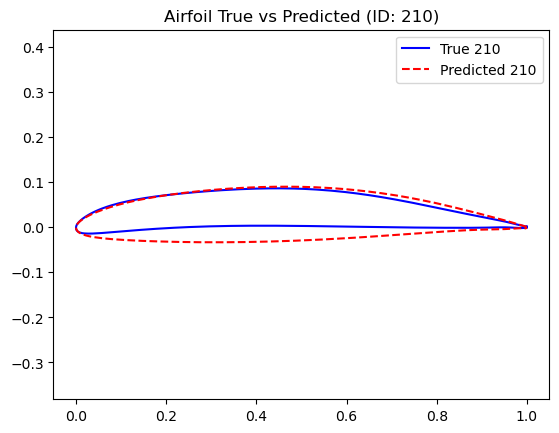

In [73]:
# Pick airfoil ID you want to plot
airfoil_id = 210
# Check if it's in the test set
if airfoil_id in test_set_idx:
    test_set_index = np.where(test_set_idx == airfoil_id)[0][0]  # index in test set

    # Plot true vs predicted
    plt.plot(airfoils_opt[airfoil_id, :, 0], airfoils_opt[airfoil_id,
             :, 1], label=f"True {airfoil_id}", color='blue')
    plt.plot(reconstructed_airfoils[test_set_index, :, 0], reconstructed_airfoils[test_set_index, :, 1],
             label=f"Predicted {airfoil_id}", color='red',linestyle='--')

    plt.axis('equal')
    plt.legend()
    plt.title(f"Airfoil True vs Predicted (ID: {airfoil_id})")
    plt.show()

else:
    print(
        f" Airfoil ID {airfoil_id} not found in validation set. Pick one from {test_idx.tolist()}")

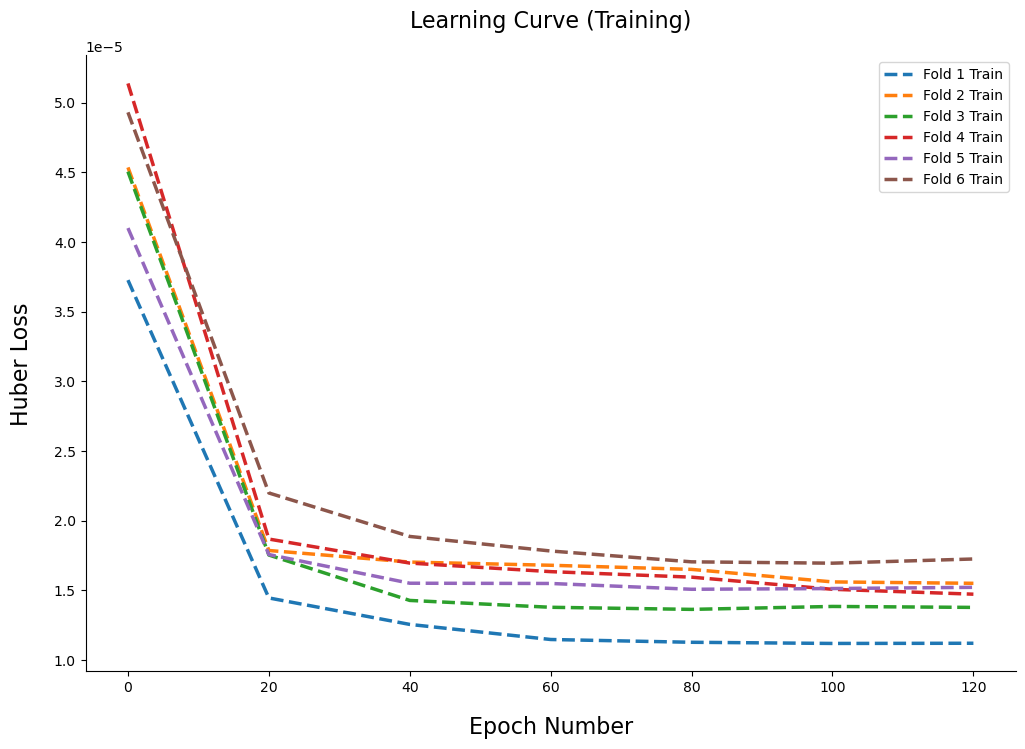

In [ ]:
x_vals = [0,20,40,60,80,100,120]
fig,axs = plt.subplots(1,1,figsize=(12,8))
for i in range(len(fold_train_loss)):

    plt.plot(x_vals, fold_train_loss[i],linewidth=2.5, linestyle='--',label=f'Fold {i+1} Train')

plt.xlabel("Epoch Number", fontsize=16,labelpad=15)
plt.ylabel("Huber Loss", fontsize=16, labelpad=15)
plt.title("Learning Curve (Training)", fontsize=16, pad=20)
plt.legend()
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)


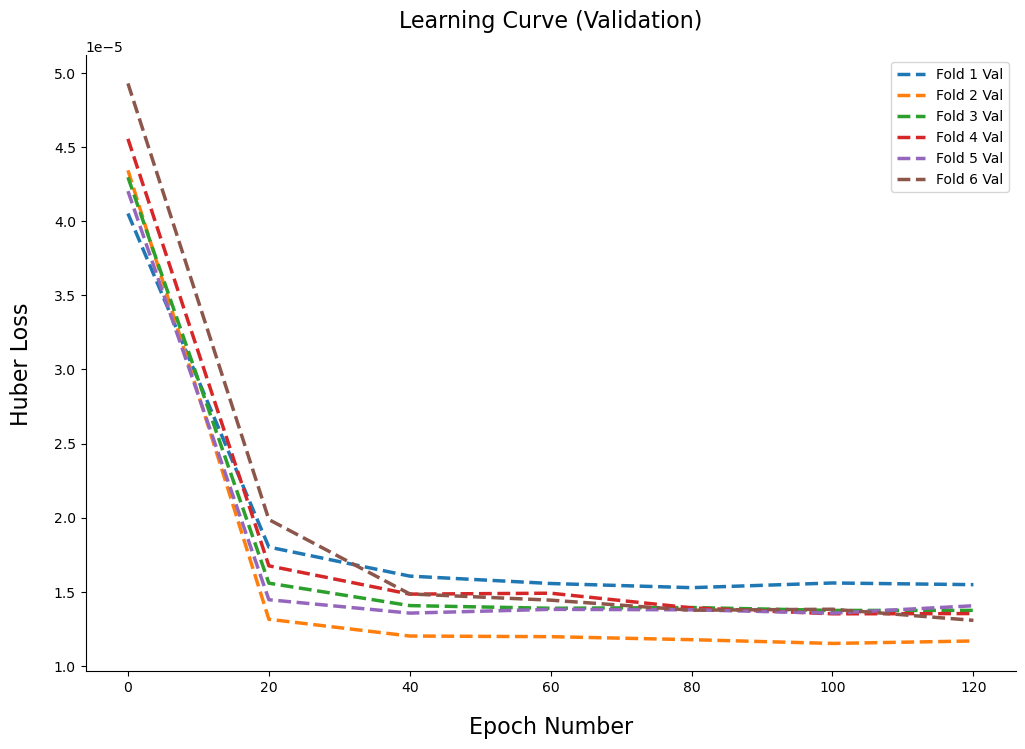

In [ ]:

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
for i in range(len(fold_val_loss)):

    plt.plot(x_vals, fold_val_loss[i], linewidth=2.5,linestyle='--',label=f'Fold {i+1} Val')

    # plt.plot(x_vals, fold_test_loss[i],label=f'Fold {i+1} Test', linestyle='--')


plt.xlabel("Epoch Number", fontsize=16, labelpad=15)
plt.ylabel("Huber Loss", fontsize=16, labelpad=15)
plt.title("Learning Curve (Validation)", fontsize=16, pad=20)
plt.legend()
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)

In [ ]:
fold_val_loss=np.array(fold_val_loss)
print(fold_val_loss.shape)
avg_val_loss = np.mean(fold_val_loss,axis=0)
avg_train_loss = np.mean(np.array(fold_train_loss),axis=0)
print(avg_val_loss)
test_loss = np.array(test_data_loss)
print(test_loss)

(6, 7)
[4.39669493e-05 1.63029476e-05 1.42305759e-05 1.40927955e-05
 1.37370477e-05 1.36219214e-05 1.35923494e-05]
[1.72873100e-04 3.25187102e-05 2.32330876e-05 2.06314089e-05
 1.85138870e-05 1.57438626e-05 1.43915468e-05]


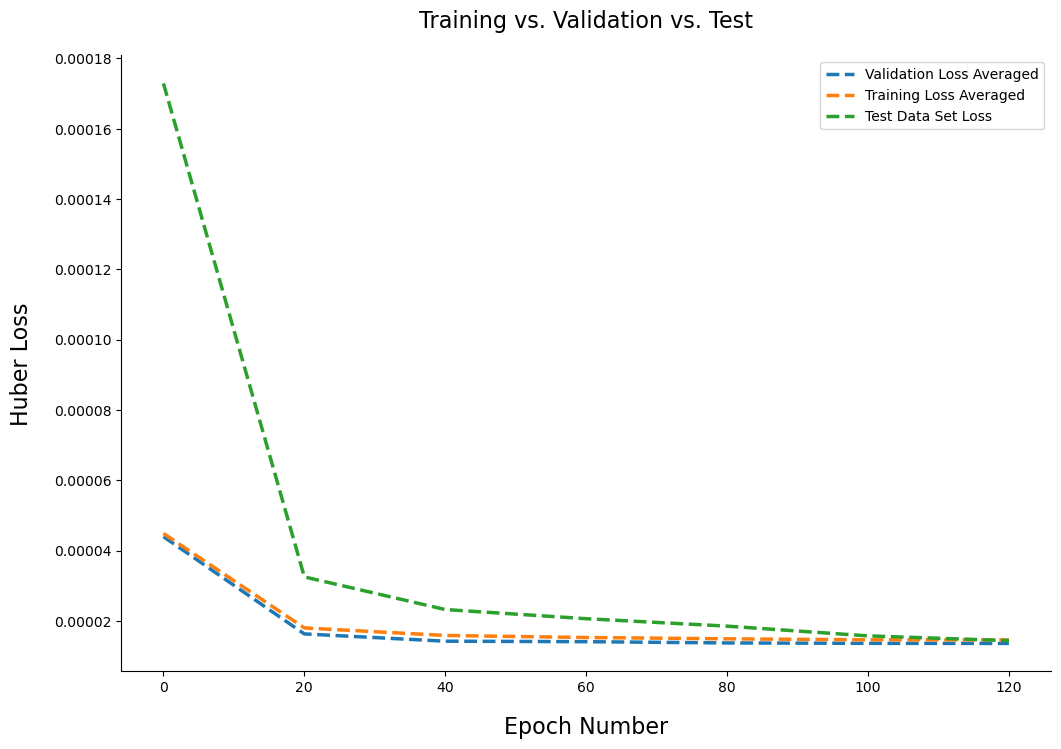

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
plt.plot(x_vals, avg_val_loss, linewidth=2.5,linestyle='--',label="Validation Loss Averaged")
plt.plot(x_vals, avg_train_loss, linewidth=2.5, linestyle='--',label="Training Loss Averaged")
plt.plot(x_vals, test_loss, linewidth=2.5,linestyle='--', label="Test Data Set Loss")


plt.xlabel("Epoch Number", fontsize=16, labelpad=15)
plt.ylabel("Huber Loss", fontsize=16, labelpad=15)
plt.title("Training vs. Validation vs. Test", fontsize=16, pad=20)
plt.legend()
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)